In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 8.0 MB/s 
     |████████████████████████████████| 86 kB 2.1 MB/s 
     |████████████████████████████████| 6.6 MB 40.4 MB/s 
     |████████████████████████████████| 596 kB 42.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
!pip install Sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 30.0 MB/s 


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.datasets import fetch_20newsgroups
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import AlbertTokenizer
from transformers import AlbertForSequenceClassification
from transformers import BertTokenizer
from transformers import ElectraTokenizer
from transformers import ElectraForSequenceClassification
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib.ticker as ticker
import time
%matplotlib inline
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

In [4]:
X_train, y_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), return_X_y=True)
X_train = X_train[:5500]
y_train = y_train[:5500]
X_test, y_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), return_X_y=True)

In [ ]:
model = ElectraForSequenceClassification.from_pretrained(
    "google/electra-small-discriminator", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 20, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/51.7M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_

In [5]:
tokenizer = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [6]:
def tokenizing(X, y, max_length=64):
    max_len = 0

    # For every sentence...
    for sent in X:

        # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
        input_ids = tokenizer.encode(sent, add_special_tokens=True)

        # Update the maximum sentence length.
        max_len = max(max_len, len(input_ids))

    # Tokenize all of the sentences and map the tokens to thier word IDs.
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in X:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = max_length,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                            #truncation=True
                    )
        
        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])
        
        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(y)
    return input_ids, attention_masks, labels

In [ ]:
# Combine the training inputs into a TensorDataset.
input_ids, attention_masks, labels = tokenizing(X_train, y_train)
dataset = TensorDataset(input_ids, attention_masks, labels)
input_ids, attention_masks, labels = tokenizing(X_test, y_test)
test_dataset = TensorDataset(input_ids, attention_masks, labels)

Token indices sequence length is longer than the specified maximum sequence length for this model (604 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

4,950 training samples
  550 validation samples


In [10]:
epochs = 20

In [8]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [9]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [11]:
import random

def training(train_dataloader, validation_dataloader, optimizer, scheduler, epochs=20):
    device='cuda'

    # This training code is based on the `run_glue.py` script here:
    # https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

    # Set the seed value all over the place to make this reproducible.
    seed_val = 42

    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    # We'll store a number of quantities such as training and validation loss, 
    # validation accuracy, and timings.
    training_stats = []

    # Measure the total training time for the whole run.
    total_t0 = time.time()

    # For each epoch...
    for epoch_i in range(0, epochs):
        
        # ========================================
        #               Training
        # ========================================
        
        # Perform one full pass over the training set.

        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Reset the total loss for this epoch.
        total_train_loss = 0
        total_train_accuracy = 0

        # Put the model into training mode. Don't be mislead--the call to 
        # `train` just changes the *mode*, it doesn't *perform* the training.
        # `dropout` and `batchnorm` layers behave differently during training
        # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):

            # Progress update every 40 batches.
            if step % 40 == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)
                
                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            # Unpack this training batch from our dataloader. 
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using the 
            # `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # Always clear any previously calculated gradients before performing a
            # backward pass. PyTorch doesn't do this automatically because 
            # accumulating the gradients is "convenient while training RNNs". 
            # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
            model.zero_grad()        

            # Perform a forward pass (evaluate the model on this training batch).
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # It returns different numbers of parameters depending on what arguments
            # arge given and what flags are set. For our useage here, it returns
            # the loss (because we provided labels) and the "logits"--the model
            # outputs prior to activation.
            an = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask, 
                                labels=b_labels)           
            loss, logits = an['loss'], an['logits']


            # Accumulate the training loss over all of the batches so that we can
            # calculate the average loss at the end. `loss` is a Tensor containing a
            # single value; the `.item()` function just returns the Python value 
            # from the tensor.
            total_train_loss += loss.item()
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            total_train_accuracy += flat_accuracy(logits, label_ids)

            # Perform a backward pass to calculate the gradients.
            loss.backward()

            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and take a step using the computed gradient.
            # The optimizer dictates the "update rule"--how the parameters are
            # modified based on their gradients, the learning rate, etc.
            optimizer.step()

            # Update the learning rate.
            scheduler.step()

        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)            
        avg_train_accuracy = total_train_accuracy / len(train_dataloader)
        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Average training accuracy: {0:.2f}".format(avg_train_accuracy))
        print("  Training epcoh took: {:}".format(training_time))
            
        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.

        print("")
        print("Running Validation...")

        t0 = time.time()

        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        model.eval()

        # Tracking variables 
        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0

        # Evaluate data for one epoch
        for batch in validation_dataloader:
            
            # Unpack this training batch from our dataloader. 
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using 
            # the `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            
            # Tell pytorch not to bother with constructing the compute graph during
            # the forward pass, since this is only needed for backprop (training).
            with torch.no_grad():        

                # Forward pass, calculate logit predictions.
                # token_type_ids is the same as the "segment ids", which 
                # differentiates sentence 1 and 2 in 2-sentence tasks.
                # The documentation for this `model` function is here: 
                # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                # Get the "logits" output by the model. The "logits" are the output
                # values prior to applying an activation function like the softmax.
                an = model(b_input_ids, 
                                      token_type_ids=None, 
                                      attention_mask=b_input_mask,
                                      labels=b_labels)            
                loss, logits = an['loss'], an['logits']

                
            # Accumulate the validation loss.
            total_eval_loss += loss.item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            total_eval_accuracy += flat_accuracy(logits, label_ids)
            

        # Report the final accuracy for this validation run.
        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(validation_dataloader)
        
        # Measure how long the validation run took.
        validation_time = format_time(time.time() - t0)
        
        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        print("  Validation took: {:}".format(validation_time))

        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Training Accur.': avg_train_accuracy,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': avg_val_accuracy,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )

    print("")
    print("Training complete!")

    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
    return training_stats

In [ ]:
batch_sizes = [16, 32, 64]
batch_dict = dict()
for b in batch_sizes:
    train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = b # Trains with this batch size.
        )
    # For validation the order doesn't matter, so we'll just read them sequentially.
    validation_dataloader = DataLoader(
                val_dataset, # The validation samples.
                sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
                batch_size = b # Evaluate with this batch size.
            )
    model = ElectraForSequenceClassification.from_pretrained(
        'google/electra-small-discriminator', # Use the 12-layer BERT model, with an uncased vocab.
        num_labels = 20, # The number of output labels--2 for binary classification.
                        # You can increase this for multi-class tasks.   
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
    )

    # Tell pytorch to run this model on the GPU.
    model.cuda()
    optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
    total_steps = len(train_dataloader) * epochs

    # Create the learning rate scheduler.
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                                num_training_steps = total_steps)
    batch_dict[b] = training(train_dataloader, validation_dataloader, optimizer, scheduler)

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier


======== Epoch 1 / 20 ========
Training...
  Batch    40  of    310.    Elapsed: 0:00:02.
  Batch    80  of    310.    Elapsed: 0:00:05.
  Batch   120  of    310.    Elapsed: 0:00:08.
  Batch   160  of    310.    Elapsed: 0:00:10.
  Batch   200  of    310.    Elapsed: 0:00:12.
  Batch   240  of    310.    Elapsed: 0:00:14.
  Batch   280  of    310.    Elapsed: 0:00:16.

  Average training loss: 2.94
  Average training accuracy: 0.11
  Training epcoh took: 0:00:17

Running Validation...
  Accuracy: 0.19
  Validation Loss: 2.81
  Validation took: 0:00:00

======== Epoch 2 / 20 ========
Training...
  Batch    40  of    310.    Elapsed: 0:00:02.
  Batch    80  of    310.    Elapsed: 0:00:04.
  Batch   120  of    310.    Elapsed: 0:00:06.
  Batch   160  of    310.    Elapsed: 0:00:08.
  Batch   200  of    310.    Elapsed: 0:00:10.
  Batch   240  of    310.    Elapsed: 0:00:12.
  Batch   280  of    310.    Elapsed: 0:00:14.

  Average training loss: 2.68
  Average training accuracy: 0.23
  

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier


======== Epoch 1 / 20 ========
Training...
  Batch    40  of    155.    Elapsed: 0:00:02.
  Batch    80  of    155.    Elapsed: 0:00:05.
  Batch   120  of    155.    Elapsed: 0:00:07.

  Average training loss: 2.97
  Average training accuracy: 0.09
  Training epcoh took: 0:00:09

Running Validation...
  Accuracy: 0.14
  Validation Loss: 2.91
  Validation took: 0:00:00

======== Epoch 2 / 20 ========
Training...
  Batch    40  of    155.    Elapsed: 0:00:02.
  Batch    80  of    155.    Elapsed: 0:00:05.
  Batch   120  of    155.    Elapsed: 0:00:07.

  Average training loss: 2.81
  Average training accuracy: 0.17
  Training epcoh took: 0:00:09

Running Validation...
  Accuracy: 0.26
  Validation Loss: 2.72
  Validation took: 0:00:00

======== Epoch 3 / 20 ========
Training...
  Batch    40  of    155.    Elapsed: 0:00:02.
  Batch    80  of    155.    Elapsed: 0:00:05.
  Batch   120  of    155.    Elapsed: 0:00:07.

  Average training loss: 2.63
  Average training accuracy: 0.26
  Trai

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier


======== Epoch 1 / 20 ========
Training...
  Batch    40  of     78.    Elapsed: 0:00:04.

  Average training loss: 2.99
  Average training accuracy: 0.08
  Training epcoh took: 0:00:09

Running Validation...
  Accuracy: 0.15
  Validation Loss: 2.97
  Validation took: 0:00:00

======== Epoch 2 / 20 ========
Training...
  Batch    40  of     78.    Elapsed: 0:00:04.

  Average training loss: 2.91
  Average training accuracy: 0.15
  Training epcoh took: 0:00:09

Running Validation...
  Accuracy: 0.19
  Validation Loss: 2.84
  Validation took: 0:00:00

======== Epoch 3 / 20 ========
Training...
  Batch    40  of     78.    Elapsed: 0:00:04.

  Average training loss: 2.77
  Average training accuracy: 0.21
  Training epcoh took: 0:00:09

Running Validation...
  Accuracy: 0.30
  Validation Loss: 2.69
  Validation took: 0:00:00

======== Epoch 4 / 20 ========
Training...
  Batch    40  of     78.    Elapsed: 0:00:04.

  Average training loss: 2.63
  Average training accuracy: 0.28
  Training

In [12]:
def show_table(training_stats):
    # Display floats with two decimal places.
    pd.set_option('precision', 2)

    # Create a DataFrame from our training statistics.
    df_stats = pd.DataFrame(data=training_stats)

    # Use the 'epoch' as the row index.
    df_stats = df_stats.set_index('epoch')

    # A hack to force the column headers to wrap.
    #df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

    # Display the table.
    return df_stats

In [ ]:
show_table(batch_dict[16])

,Training Loss,Training Accur.,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,,
1,2.94,0.11,2.81,0.19,0:00:17,0:00:00
2,2.68,0.23,2.55,0.26,0:00:16,0:00:01
3,2.43,0.30,2.35,0.29,0:00:16,0:00:00
4,2.21,0.36,2.16,0.38,0:00:15,0:00:00
5,2.03,0.42,2.04,0.42,0:00:15,0:00:00
6,1.86,0.47,1.95,0.46,0:00:15,0:00:00
7,1.73,0.50,1.87,0.45,0:00:15,0:00:00
8,1.61,0.52,1.81,0.49,0:00:15,0:00:00
9,1.50,0.54,1.76,0.48,0:00:15,0:00:00


In [ ]:
show_table(batch_dict[32])

,Training Loss,Training Accur.,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,,
1,2.97,0.09,2.91,0.14,0:00:09,0:00:00
2,2.81,0.17,2.72,0.26,0:00:09,0:00:00
3,2.63,0.26,2.57,0.30,0:00:09,0:00:00
4,2.48,0.32,2.43,0.34,0:00:09,0:00:00
5,2.33,0.36,2.30,0.37,0:00:09,0:00:00
6,2.20,0.40,2.20,0.39,0:00:09,0:00:00
7,2.08,0.43,2.11,0.41,0:00:09,0:00:00
8,1.99,0.45,2.05,0.41,0:00:09,0:00:00
9,1.90,0.46,1.98,0.41,0:00:09,0:00:00


In [ ]:
show_table(batch_dict[64])

,Training Loss,Training Accur.,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,,
1,2.99,0.08,2.97,0.15,0:00:09,0:00:00
2,2.91,0.15,2.84,0.19,0:00:09,0:00:00
3,2.77,0.21,2.69,0.30,0:00:09,0:00:00
4,2.63,0.28,2.57,0.31,0:00:09,0:00:00
5,2.52,0.32,2.47,0.34,0:00:09,0:00:00
6,2.42,0.36,2.39,0.36,0:00:09,0:00:00
7,2.33,0.38,2.32,0.38,0:00:09,0:00:00
8,2.24,0.41,2.25,0.39,0:00:09,0:00:00
9,2.17,0.43,2.20,0.39,0:00:09,0:00:00


In [ ]:
loss_train = dict()
loss_test = dict()
acc_train = dict()
acc_test = dict()
for key in batch_dict:
    for list_ in batch_dict[key]:
        if key in loss_train:
            loss_train[key].append(list_['Training Loss'])
            loss_test[key].append(list_['Valid. Loss'])
            acc_test[key].append(list_['Valid. Accur.'])
            acc_train[key].append(list_['Training Accur.'])
        else:
            loss_train[key] = [list_['Training Loss']]
            loss_test[key] = [list_['Valid. Loss']]
            acc_test[key] = [list_['Valid. Accur.']]
            acc_train[key] = [list_['Training Accur.']]

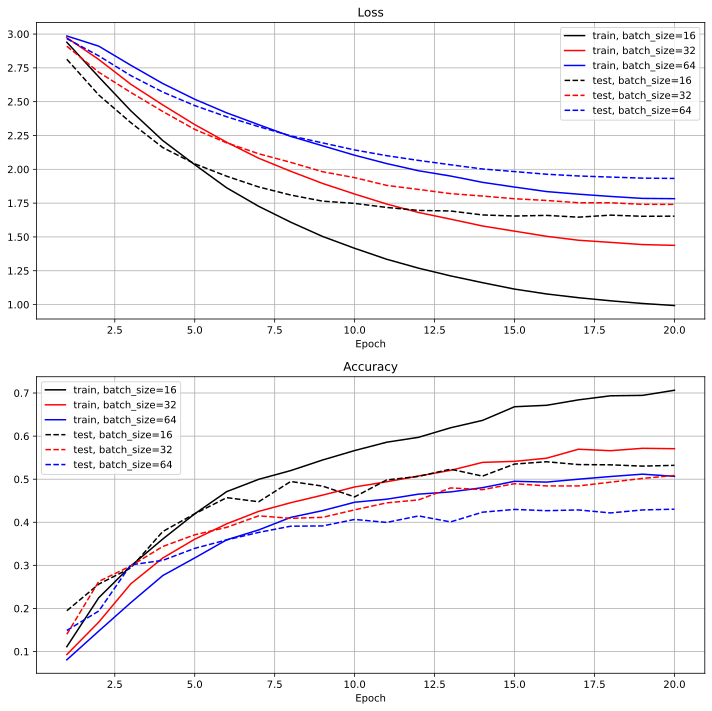

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

axes[0].plot(np.arange(20) + 1, loss_train[16], label='train, batch_size=16', linestyle='-', c='black')
axes[0].plot(np.arange(20) + 1, loss_train[32], label='train, batch_size=32', linestyle='-', c='r')
axes[0].plot(np.arange(20) + 1, loss_train[64], label='train, batch_size=64', linestyle='-', c='b')

axes[0].plot(np.arange(20) + 1, loss_test[16], label='test, batch_size=16', linestyle='--', c='black')
axes[0].plot(np.arange(20) + 1, loss_test[32], label='test, batch_size=32', linestyle='--', c='r')
axes[0].plot(np.arange(20) + 1, loss_test[64], label='test, batch_size=64', linestyle='--', c='b')

axes[1].plot(np.arange(20) + 1, acc_train[16], label='train, batch_size=16', linestyle='-', c='black')
axes[1].plot(np.arange(20) + 1, acc_train[32], label='train, batch_size=32', linestyle='-', c='r')
axes[1].plot(np.arange(20) + 1, acc_train[64], label='train, batch_size=64', linestyle='-', c='b')

axes[1].plot(np.arange(20) + 1, acc_test[16], label='test, batch_size=16', linestyle='--', c='black')
axes[1].plot(np.arange(20) + 1, acc_test[32], label='test, batch_size=32', linestyle='--', c='r')
axes[1].plot(np.arange(20) + 1, acc_test[64], label='test, batch_size=64', linestyle='--', c='b')

axes[0].legend()
axes[0].grid(True)
axes[0].set_xlabel('Epoch')
axes[0].set_title('Loss')

axes[1].legend()
axes[1].grid(True)
axes[1].set_xlabel('Epoch')
axes[1].set_title('Accuracy')

fig.tight_layout()
plt.show()

Лучший результат получается при 16, но в целях экономии времени будем использовать 32.

In [ ]:
lrs = [5e-5, 4e-5, 3e-5, 2e-5]
lrs_dict = dict()
for lr in lrs:
    train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = 32 # Trains with this batch size.
        )

    # For validation the order doesn't matter, so we'll just read them sequentially.
    validation_dataloader = DataLoader(
                val_dataset, # The validation samples.
                sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
                batch_size = 32 # Evaluate with this batch size.
            )
    model = ElectraForSequenceClassification.from_pretrained(
        'google/electra-small-discriminator', # Use the 12-layer BERT model, with an uncased vocab.
        num_labels = 20, # The number of output labels--2 for binary classification.
                        # You can increase this for multi-class tasks.   
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
    )

    # Tell pytorch to run this model on the GPU.
    model.cuda()
    optimizer = AdamW(model.parameters(),
                  lr = lr, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
    total_steps = len(train_dataloader) * epochs

    # Create the learning rate scheduler.
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                                num_training_steps = total_steps)
    lrs_dict[lr] = training(train_dataloader, validation_dataloader, optimizer, scheduler)

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier


======== Epoch 1 / 20 ========
Training...
  Batch    40  of    155.    Elapsed: 0:00:04.
  Batch    80  of    155.    Elapsed: 0:00:08.
  Batch   120  of    155.    Elapsed: 0:00:10.

  Average training loss: 2.89
  Average training accuracy: 0.13
  Training epcoh took: 0:00:12

Running Validation...
  Accuracy: 0.26
  Validation Loss: 2.69
  Validation took: 0:00:00

======== Epoch 2 / 20 ========
Training...
  Batch    40  of    155.    Elapsed: 0:00:02.
  Batch    80  of    155.    Elapsed: 0:00:05.
  Batch   120  of    155.    Elapsed: 0:00:07.

  Average training loss: 2.50
  Average training accuracy: 0.29
  Training epcoh took: 0:00:09

Running Validation...
  Accuracy: 0.34
  Validation Loss: 2.35
  Validation took: 0:00:00

======== Epoch 3 / 20 ========
Training...
  Batch    40  of    155.    Elapsed: 0:00:02.
  Batch    80  of    155.    Elapsed: 0:00:04.
  Batch   120  of    155.    Elapsed: 0:00:07.

  Average training loss: 2.16
  Average training accuracy: 0.39
  Trai

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier


======== Epoch 1 / 20 ========
Training...
  Batch    40  of    155.    Elapsed: 0:00:02.
  Batch    80  of    155.    Elapsed: 0:00:05.
  Batch   120  of    155.    Elapsed: 0:00:07.

  Average training loss: 2.92
  Average training accuracy: 0.12
  Training epcoh took: 0:00:09

Running Validation...
  Accuracy: 0.24
  Validation Loss: 2.75
  Validation took: 0:00:00

======== Epoch 2 / 20 ========
Training...
  Batch    40  of    155.    Elapsed: 0:00:02.
  Batch    80  of    155.    Elapsed: 0:00:05.
  Batch   120  of    155.    Elapsed: 0:00:07.

  Average training loss: 2.59
  Average training accuracy: 0.26
  Training epcoh took: 0:00:09

Running Validation...
  Accuracy: 0.33
  Validation Loss: 2.44
  Validation took: 0:00:00

======== Epoch 3 / 20 ========
Training...
  Batch    40  of    155.    Elapsed: 0:00:02.
  Batch    80  of    155.    Elapsed: 0:00:05.
  Batch   120  of    155.    Elapsed: 0:00:07.

  Average training loss: 2.28
  Average training accuracy: 0.38
  Trai

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier


======== Epoch 1 / 20 ========
Training...
  Batch    40  of    155.    Elapsed: 0:00:02.
  Batch    80  of    155.    Elapsed: 0:00:05.
  Batch   120  of    155.    Elapsed: 0:00:07.

  Average training loss: 2.94
  Average training accuracy: 0.11
  Training epcoh took: 0:00:09

Running Validation...
  Accuracy: 0.18
  Validation Loss: 2.82
  Validation took: 0:00:00

======== Epoch 2 / 20 ========
Training...
  Batch    40  of    155.    Elapsed: 0:00:02.
  Batch    80  of    155.    Elapsed: 0:00:05.
  Batch   120  of    155.    Elapsed: 0:00:07.

  Average training loss: 2.69
  Average training accuracy: 0.23
  Training epcoh took: 0:00:09

Running Validation...
  Accuracy: 0.31
  Validation Loss: 2.57
  Validation took: 0:00:00

======== Epoch 3 / 20 ========
Training...
  Batch    40  of    155.    Elapsed: 0:00:02.
  Batch    80  of    155.    Elapsed: 0:00:05.
  Batch   120  of    155.    Elapsed: 0:00:07.

  Average training loss: 2.44
  Average training accuracy: 0.33
  Trai

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier


======== Epoch 1 / 20 ========
Training...
  Batch    40  of    155.    Elapsed: 0:00:02.
  Batch    80  of    155.    Elapsed: 0:00:05.
  Batch   120  of    155.    Elapsed: 0:00:07.

  Average training loss: 2.97
  Average training accuracy: 0.09
  Training epcoh took: 0:00:09

Running Validation...
  Accuracy: 0.14
  Validation Loss: 2.91
  Validation took: 0:00:00

======== Epoch 2 / 20 ========
Training...
  Batch    40  of    155.    Elapsed: 0:00:02.
  Batch    80  of    155.    Elapsed: 0:00:05.
  Batch   120  of    155.    Elapsed: 0:00:07.

  Average training loss: 2.81
  Average training accuracy: 0.17
  Training epcoh took: 0:00:09

Running Validation...
  Accuracy: 0.26
  Validation Loss: 2.72
  Validation took: 0:00:00

======== Epoch 3 / 20 ========
Training...
  Batch    40  of    155.    Elapsed: 0:00:02.
  Batch    80  of    155.    Elapsed: 0:00:05.
  Batch   120  of    155.    Elapsed: 0:00:07.

  Average training loss: 2.63
  Average training accuracy: 0.26
  Trai

In [ ]:
show_table(lrs_dict[5e-5])

,Training Loss,Training Accur.,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,,
1,2.89,0.13,2.69,0.26,0:00:12,0:00:00
2,2.50,0.29,2.35,0.34,0:00:09,0:00:00
3,2.16,0.39,2.11,0.38,0:00:09,0:00:00
4,1.88,0.44,1.92,0.41,0:00:09,0:00:00
5,1.66,0.49,1.82,0.42,0:00:09,0:00:00
6,1.48,0.54,1.74,0.48,0:00:09,0:00:00
7,1.33,0.59,1.69,0.50,0:00:10,0:00:00
8,1.20,0.62,1.65,0.52,0:00:09,0:00:00
9,1.09,0.67,1.65,0.54,0:00:09,0:00:00


In [ ]:
show_table(lrs_dict[4e-5])

,Training Loss,Training Accur.,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,,
1,2.92,0.12,2.75,0.24,0:00:09,0:00:00
2,2.59,0.26,2.44,0.33,0:00:09,0:00:00
3,2.28,0.38,2.20,0.37,0:00:09,0:00:00
4,2.02,0.42,2.00,0.41,0:00:09,0:00:00
5,1.80,0.48,1.88,0.42,0:00:09,0:00:00
6,1.62,0.51,1.79,0.50,0:00:09,0:00:00
7,1.47,0.55,1.73,0.50,0:00:09,0:00:00
8,1.35,0.59,1.71,0.50,0:00:09,0:00:00
9,1.25,0.63,1.63,0.54,0:00:09,0:00:00


In [ ]:
show_table(lrs_dict[3e-5])

,Training Loss,Training Accur.,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,,
1,2.94,0.11,2.82,0.18,0:00:09,0:00:00
2,2.69,0.23,2.57,0.31,0:00:09,0:00:00
3,2.44,0.33,2.37,0.35,0:00:09,0:00:00
4,2.22,0.39,2.17,0.39,0:00:09,0:00:00
5,2.02,0.44,2.04,0.39,0:00:09,0:00:00
6,1.86,0.46,1.93,0.46,0:00:09,0:00:00
7,1.72,0.50,1.86,0.48,0:00:09,0:00:00
8,1.60,0.53,1.82,0.48,0:00:09,0:00:00
9,1.50,0.56,1.73,0.52,0:00:09,0:00:00


In [ ]:
show_table(lrs_dict[2e-5])

,Training Loss,Training Accur.,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,,
1,2.97,0.09,2.91,0.14,0:00:09,0:00:00
2,2.81,0.17,2.72,0.26,0:00:09,0:00:00
3,2.63,0.26,2.57,0.30,0:00:09,0:00:00
4,2.48,0.32,2.43,0.34,0:00:09,0:00:00
5,2.33,0.36,2.30,0.37,0:00:09,0:00:00
6,2.20,0.40,2.20,0.39,0:00:09,0:00:00
7,2.08,0.43,2.11,0.41,0:00:09,0:00:00
8,1.99,0.45,2.05,0.41,0:00:09,0:00:00
9,1.90,0.46,1.98,0.41,0:00:09,0:00:00


In [ ]:
loss_train = dict()
loss_test = dict()
acc_train = dict()
acc_test = dict()
for key in lrs_dict:
    for list_ in lrs_dict[key]:
        if key in loss_train:
            loss_train[key].append(list_['Training Loss'])
            loss_test[key].append(list_['Valid. Loss'])
            acc_test[key].append(list_['Valid. Accur.'])
            acc_train[key].append(list_['Training Accur.'])
        else:
            loss_train[key] = [list_['Training Loss']]
            loss_test[key] = [list_['Valid. Loss']]
            acc_test[key] = [list_['Valid. Accur.']]
            acc_train[key] = [list_['Training Accur.']]

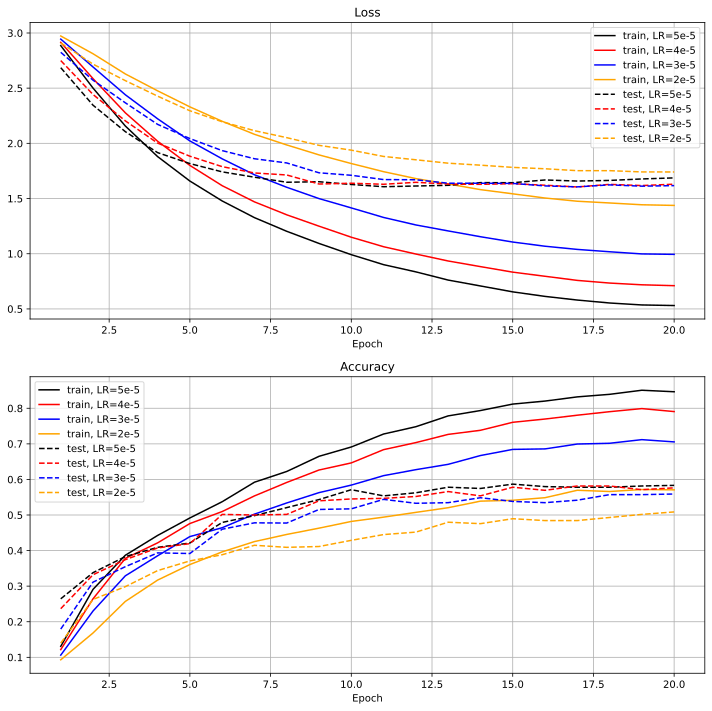

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

axes[0].plot(np.arange(20) + 1, loss_train[5e-5], label='train, LR=5e-5', linestyle='-', c='black')
axes[0].plot(np.arange(20) + 1, loss_train[4e-5], label='train, LR=4e-5', linestyle='-', c='r')
axes[0].plot(np.arange(20) + 1, loss_train[3e-5], label='train, LR=3e-5', linestyle='-', c='b')
axes[0].plot(np.arange(20) + 1, loss_train[2e-5], label='train, LR=2e-5', linestyle='-', c='orange')

axes[0].plot(np.arange(20) + 1, loss_test[5e-5], label='test, LR=5e-5', linestyle='--', c='black')
axes[0].plot(np.arange(20) + 1, loss_test[4e-5], label='test, LR=4e-5', linestyle='--', c='r')
axes[0].plot(np.arange(20) + 1, loss_test[3e-5], label='test, LR=3e-5', linestyle='--', c='b')
axes[0].plot(np.arange(20) + 1, loss_test[2e-5], label='test, LR=2e-5', linestyle='--', c='orange')

axes[1].plot(np.arange(20) + 1, acc_train[5e-5], label='train, LR=5e-5', linestyle='-', c='black')
axes[1].plot(np.arange(20) + 1, acc_train[4e-5], label='train, LR=4e-5', linestyle='-', c='r')
axes[1].plot(np.arange(20) + 1, acc_train[3e-5], label='train, LR=3e-5', linestyle='-', c='b')
axes[1].plot(np.arange(20) + 1, acc_train[2e-5], label='train, LR=2e-5', linestyle='-', c='orange')

axes[1].plot(np.arange(20) + 1, acc_test[5e-5], label='test, LR=5e-5', linestyle='--', c='black')
axes[1].plot(np.arange(20) + 1, acc_test[4e-5], label='test, LR=4e-5', linestyle='--', c='r')
axes[1].plot(np.arange(20) + 1, acc_test[3e-5], label='test, LR=3e-5', linestyle='--', c='b')
axes[1].plot(np.arange(20) + 1, acc_test[2e-5], label='test, LR=2e-5', linestyle='--', c='orange')

axes[0].legend()
axes[0].grid(True)
axes[0].set_xlabel('Epoch')
axes[0].set_title('Loss')

axes[1].legend()
axes[1].grid(True)
axes[1].set_xlabel('Epoch')
axes[1].set_title('Accuracy')

fig.tight_layout()
plt.show()

Лучший результат - при 5e-5, но будем, в целях экономии времени использовать предыдущее значение.

In [ ]:
max_lens = [25, 50, 70, 100]
ml_dict = dict()
for ml in max_lens:
    input_ids, attention_masks, labels = tokenizing(X_train, y_train, max_length=ml)
    dataset = TensorDataset(input_ids, attention_masks, labels)
    train_size = int(0.9 * len(dataset))
    val_size = len(dataset) - train_size

    # Divide the dataset by randomly selecting samples.
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = 32 # Trains with this batch size.
        )

    # For validation the order doesn't matter, so we'll just read them sequentially.
    validation_dataloader = DataLoader(
                val_dataset, # The validation samples.
                sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
                batch_size = 32 # Evaluate with this batch size.
            )
    model = ElectraForSequenceClassification.from_pretrained(
        'google/electra-small-discriminator', # Use the 12-layer BERT model, with an uncased vocab.
        num_labels = 20, # The number of output labels--2 for binary classification.
                        # You can increase this for multi-class tasks.   
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
    )

    # Tell pytorch to run this model on the GPU.
    model.cuda()
    optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
    total_steps = len(train_dataloader) * epochs

    # Create the learning rate scheduler.
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                                num_training_steps = total_steps)
    ml_dict[ml] = training(train_dataloader, validation_dataloader, optimizer, scheduler)

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier


======== Epoch 1 / 20 ========
Training...
  Batch    40  of    155.    Elapsed: 0:00:02.
  Batch    80  of    155.    Elapsed: 0:00:04.
  Batch   120  of    155.    Elapsed: 0:00:06.

  Average training loss: 2.98
  Average training accuracy: 0.08
  Training epcoh took: 0:00:08

Running Validation...
  Accuracy: 0.13
  Validation Loss: 2.93
  Validation took: 0:00:00

======== Epoch 2 / 20 ========
Training...
  Batch    40  of    155.    Elapsed: 0:00:02.
  Batch    80  of    155.    Elapsed: 0:00:04.
  Batch   120  of    155.    Elapsed: 0:00:06.

  Average training loss: 2.87
  Average training accuracy: 0.15
  Training epcoh took: 0:00:08

Running Validation...
  Accuracy: 0.17
  Validation Loss: 2.79
  Validation took: 0:00:00

======== Epoch 3 / 20 ========
Training...
  Batch    40  of    155.    Elapsed: 0:00:02.
  Batch    80  of    155.    Elapsed: 0:00:05.
  Batch   120  of    155.    Elapsed: 0:00:07.

  Average training loss: 2.74
  Average training accuracy: 0.17
  Trai

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier


======== Epoch 1 / 20 ========
Training...
  Batch    40  of    155.    Elapsed: 0:00:02.
  Batch    80  of    155.    Elapsed: 0:00:04.
  Batch   120  of    155.    Elapsed: 0:00:06.

  Average training loss: 2.96
  Average training accuracy: 0.09
  Training epcoh took: 0:00:08

Running Validation...
  Accuracy: 0.18
  Validation Loss: 2.87
  Validation took: 0:00:00

======== Epoch 2 / 20 ========
Training...
  Batch    40  of    155.    Elapsed: 0:00:02.
  Batch    80  of    155.    Elapsed: 0:00:04.
  Batch   120  of    155.    Elapsed: 0:00:06.

  Average training loss: 2.78
  Average training accuracy: 0.18
  Training epcoh took: 0:00:08

Running Validation...
  Accuracy: 0.20
  Validation Loss: 2.69
  Validation took: 0:00:00

======== Epoch 3 / 20 ========
Training...
  Batch    40  of    155.    Elapsed: 0:00:02.
  Batch    80  of    155.    Elapsed: 0:00:04.
  Batch   120  of    155.    Elapsed: 0:00:06.

  Average training loss: 2.62
  Average training accuracy: 0.22
  Trai

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier


======== Epoch 1 / 20 ========
Training...
  Batch    40  of    155.    Elapsed: 0:00:03.
  Batch    80  of    155.    Elapsed: 0:00:05.
  Batch   120  of    155.    Elapsed: 0:00:07.

  Average training loss: 2.96
  Average training accuracy: 0.10
  Training epcoh took: 0:00:10

Running Validation...
  Accuracy: 0.19
  Validation Loss: 2.86
  Validation took: 0:00:00

======== Epoch 2 / 20 ========
Training...
  Batch    40  of    155.    Elapsed: 0:00:03.
  Batch    80  of    155.    Elapsed: 0:00:05.
  Batch   120  of    155.    Elapsed: 0:00:08.

  Average training loss: 2.77
  Average training accuracy: 0.19
  Training epcoh took: 0:00:10

Running Validation...
  Accuracy: 0.21
  Validation Loss: 2.66
  Validation took: 0:00:00

======== Epoch 3 / 20 ========
Training...
  Batch    40  of    155.    Elapsed: 0:00:03.
  Batch    80  of    155.    Elapsed: 0:00:05.
  Batch   120  of    155.    Elapsed: 0:00:08.

  Average training loss: 2.59
  Average training accuracy: 0.24
  Trai

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier


======== Epoch 1 / 20 ========
Training...
  Batch    40  of    155.    Elapsed: 0:00:04.
  Batch    80  of    155.    Elapsed: 0:00:08.
  Batch   120  of    155.    Elapsed: 0:00:12.

  Average training loss: 2.95
  Average training accuracy: 0.10
  Training epcoh took: 0:00:15

Running Validation...
  Accuracy: 0.17
  Validation Loss: 2.84
  Validation took: 0:00:01

======== Epoch 2 / 20 ========
Training...
  Batch    40  of    155.    Elapsed: 0:00:04.
  Batch    80  of    155.    Elapsed: 0:00:08.
  Batch   120  of    155.    Elapsed: 0:00:12.

  Average training loss: 2.75
  Average training accuracy: 0.20
  Training epcoh took: 0:00:15

Running Validation...
  Accuracy: 0.22
  Validation Loss: 2.63
  Validation took: 0:00:01

======== Epoch 3 / 20 ========
Training...
  Batch    40  of    155.    Elapsed: 0:00:04.
  Batch    80  of    155.    Elapsed: 0:00:08.
  Batch   120  of    155.    Elapsed: 0:00:12.

  Average training loss: 2.56
  Average training accuracy: 0.25
  Trai

In [ ]:
show_table(ml_dict[25])

,Training Loss,Training Accur.,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,,
1,2.98,0.08,2.93,0.13,0:00:08,0:00:00
2,2.87,0.15,2.79,0.17,0:00:08,0:00:00
3,2.74,0.17,2.69,0.19,0:00:09,0:00:00
4,2.64,0.19,2.62,0.19,0:00:09,0:00:00
5,2.55,0.21,2.55,0.21,0:00:08,0:00:00
6,2.47,0.24,2.49,0.23,0:00:08,0:00:00
7,2.40,0.25,2.43,0.25,0:00:08,0:00:00
8,2.33,0.27,2.39,0.25,0:00:08,0:00:00
9,2.26,0.29,2.35,0.26,0:00:08,0:00:00


In [ ]:
show_table(ml_dict[50])

,Training Loss,Training Accur.,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,,
1,2.96,0.09,2.87,0.18,0:00:08,0:00:00
2,2.78,0.18,2.69,0.20,0:00:08,0:00:00
3,2.62,0.22,2.55,0.27,0:00:08,0:00:00
4,2.49,0.26,2.45,0.26,0:00:08,0:00:00
5,2.37,0.30,2.35,0.30,0:00:08,0:00:00
6,2.27,0.31,2.26,0.33,0:00:09,0:00:00
7,2.17,0.34,2.20,0.33,0:00:08,0:00:00
8,2.08,0.36,2.15,0.33,0:00:08,0:00:00
9,2.00,0.39,2.10,0.36,0:00:08,0:00:00


In [ ]:
show_table(ml_dict[70])

,Training Loss,Training Accur.,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,,
1,2.96,0.10,2.86,0.19,0:00:10,0:00:00
2,2.77,0.19,2.66,0.21,0:00:10,0:00:00
3,2.59,0.24,2.51,0.28,0:00:10,0:00:00
4,2.45,0.29,2.40,0.29,0:00:10,0:00:00
5,2.32,0.32,2.27,0.34,0:00:10,0:00:00
6,2.20,0.34,2.20,0.34,0:00:10,0:00:00
7,2.10,0.39,2.12,0.36,0:00:10,0:00:00
8,2.00,0.42,2.06,0.39,0:00:10,0:00:00
9,1.91,0.44,2.00,0.41,0:00:10,0:00:00


In [ ]:
show_table(ml_dict[100])

,Training Loss,Training Accur.,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,,
1,2.95,0.10,2.84,0.17,0:00:15,0:00:01
2,2.75,0.20,2.63,0.22,0:00:15,0:00:01
3,2.56,0.25,2.47,0.28,0:00:15,0:00:01
4,2.41,0.29,2.36,0.30,0:00:15,0:00:01
5,2.27,0.33,2.23,0.34,0:00:15,0:00:01
6,2.14,0.36,2.14,0.36,0:00:15,0:00:01
7,2.04,0.39,2.06,0.38,0:00:15,0:00:01
8,1.94,0.43,1.99,0.40,0:00:15,0:00:01
9,1.85,0.45,1.93,0.41,0:00:15,0:00:01


In [ ]:
loss_train = dict()
loss_test = dict()
acc_train = dict()
acc_test = dict()
for key in ml_dict:
    for list_ in ml_dict[key]:
        if key in loss_train:
            loss_train[key].append(list_['Training Loss'])
            loss_test[key].append(list_['Valid. Loss'])
            acc_test[key].append(list_['Valid. Accur.'])
            acc_train[key].append(list_['Training Accur.'])
        else:
            loss_train[key] = [list_['Training Loss']]
            loss_test[key] = [list_['Valid. Loss']]
            acc_test[key] = [list_['Valid. Accur.']]
            acc_train[key] = [list_['Training Accur.']]

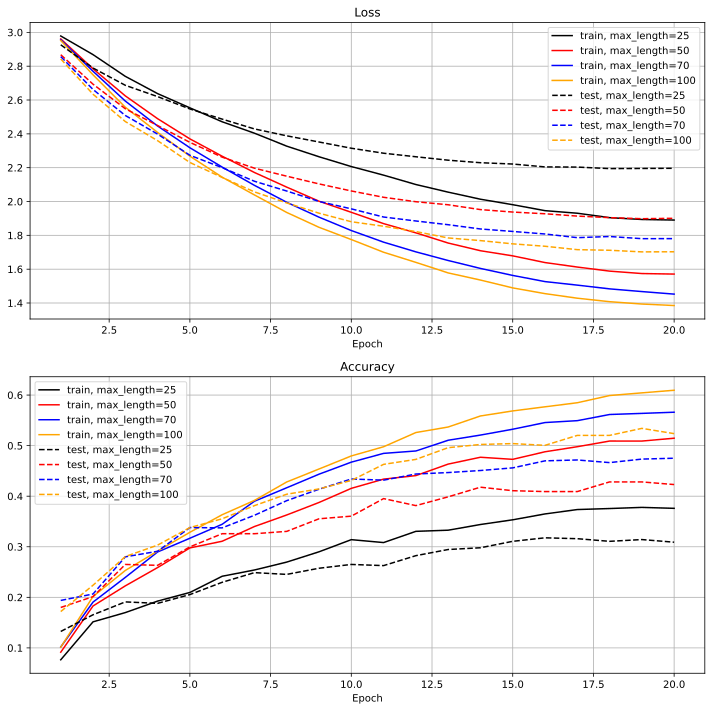

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

axes[0].plot(np.arange(20) + 1, loss_train[25], label='train, max_length=25', linestyle='-', c='black')
axes[0].plot(np.arange(20) + 1, loss_train[50], label='train, max_length=50', linestyle='-', c='r')
axes[0].plot(np.arange(20) + 1, loss_train[70], label='train, max_length=70', linestyle='-', c='b')
axes[0].plot(np.arange(20) + 1, loss_train[100], label='train, max_length=100', linestyle='-', c='orange')

axes[0].plot(np.arange(20) + 1, loss_test[25], label='test, max_length=25', linestyle='--', c='black')
axes[0].plot(np.arange(20) + 1, loss_test[50], label='test, max_length=50', linestyle='--', c='r')
axes[0].plot(np.arange(20) + 1, loss_test[70], label='test, max_length=70', linestyle='--', c='b')
axes[0].plot(np.arange(20) + 1, loss_test[100], label='test, max_length=100', linestyle='--', c='orange')

axes[1].plot(np.arange(20) + 1, acc_train[25], label='train, max_length=25', linestyle='-', c='black')
axes[1].plot(np.arange(20) + 1, acc_train[50], label='train, max_length=50', linestyle='-', c='r')
axes[1].plot(np.arange(20) + 1, acc_train[70], label='train, max_length=70', linestyle='-', c='b')
axes[1].plot(np.arange(20) + 1, acc_train[100], label='train, max_length=100', linestyle='-', c='orange')

axes[1].plot(np.arange(20) + 1, acc_test[25], label='test, max_length=25', linestyle='--', c='black')
axes[1].plot(np.arange(20) + 1, acc_test[50], label='test, max_length=50', linestyle='--', c='r')
axes[1].plot(np.arange(20) + 1, acc_test[70], label='test, max_length=70', linestyle='--', c='b')
axes[1].plot(np.arange(20) + 1, acc_test[100], label='test, max_length=100', linestyle='--', c='orange')

axes[0].legend()
axes[0].grid(True)
axes[0].set_xlabel('Epoch')
axes[0].set_title('Loss')

axes[1].legend()
axes[1].grid(True)
axes[1].set_xlabel('Epoch')
axes[1].set_title('Accuracy')

fig.tight_layout()
plt.show()

Оставляем 100, улучшений нет.

In [ ]:
input_ids, attention_masks, labels = tokenizing(X_train, y_train, max_length=100)
dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_dataloader = DataLoader(
        train_dataset,  # The training samples.
        sampler = RandomSampler(train_dataset), # Select batches randomly
        batch_size = 16 # Trains with this batch size.
    )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = 16 # Evaluate with this batch size.
        )
model = ElectraForSequenceClassification.from_pretrained(
    'google/electra-small-discriminator', # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 20, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()
optimizer = AdamW(model.parameters(),
                lr = 5e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
            )
total_steps = len(train_dataloader) * 40

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
res1 = training(train_dataloader, validation_dataloader, optimizer, scheduler, epochs=40)

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier


======== Epoch 1 / 40 ========
Training...
  Batch    40  of    310.    Elapsed: 0:00:02.
  Batch    80  of    310.    Elapsed: 0:00:04.
  Batch   120  of    310.    Elapsed: 0:00:06.
  Batch   160  of    310.    Elapsed: 0:00:08.
  Batch   200  of    310.    Elapsed: 0:00:10.
  Batch   240  of    310.    Elapsed: 0:00:13.
  Batch   280  of    310.    Elapsed: 0:00:15.

  Average training loss: 2.76
  Average training accuracy: 0.19
  Training epcoh took: 0:00:16

Running Validation...
  Accuracy: 0.28
  Validation Loss: 2.42
  Validation took: 0:00:01

======== Epoch 2 / 40 ========
Training...
  Batch    40  of    310.    Elapsed: 0:00:02.
  Batch    80  of    310.    Elapsed: 0:00:05.
  Batch   120  of    310.    Elapsed: 0:00:07.
  Batch   160  of    310.    Elapsed: 0:00:09.
  Batch   200  of    310.    Elapsed: 0:00:11.
  Batch   240  of    310.    Elapsed: 0:00:13.
  Batch   280  of    310.    Elapsed: 0:00:15.

  Average training loss: 2.18
  Average training accuracy: 0.34
  

In [ ]:
show_table(res1)

,Training Loss,Training Accur.,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,,
1,2.76,0.19,2.42,0.28,0:00:16,0:00:01
2,2.18,0.34,1.99,0.39,0:00:17,0:00:01
3,1.75,0.46,1.74,0.47,0:00:17,0:00:01
4,1.46,0.54,1.59,0.53,0:00:16,0:00:01
5,1.24,0.62,1.49,0.55,0:00:17,0:00:01
6,1.05,0.67,1.48,0.55,0:00:16,0:00:01
7,0.88,0.73,1.45,0.59,0:00:16,0:00:01
8,0.75,0.77,1.48,0.60,0:00:17,0:00:01
9,0.65,0.79,1.52,0.59,0:00:16,0:00:01


In [ ]:
loss_train = []
loss_test = []
acc_train = []
acc_test = []
for list_ in res1:
    loss_train.append(list_['Training Loss'])
    loss_test.append(list_['Valid. Loss'])
    acc_test.append(list_['Valid. Accur.'])
    acc_train.append(list_['Training Accur.'])

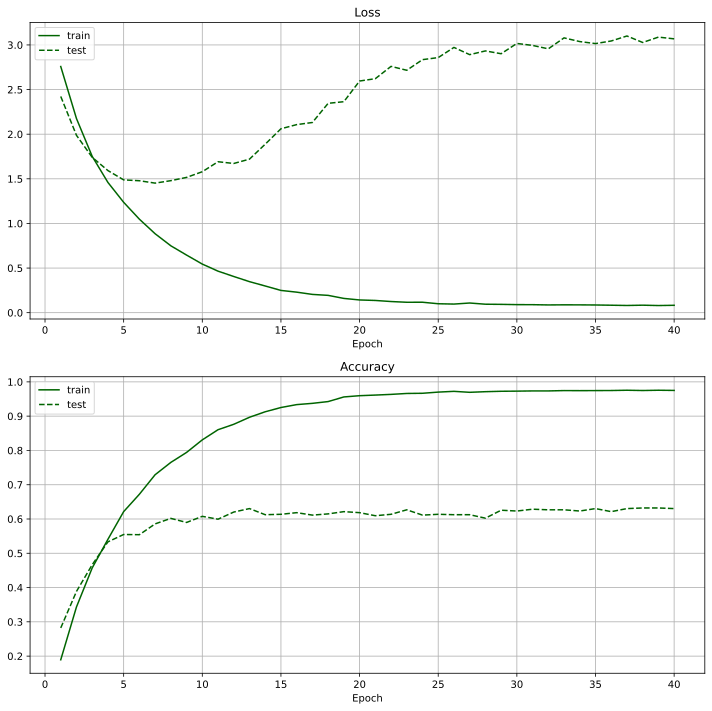

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

axes[0].plot(np.arange(40) + 1, loss_train, label='train', linestyle='-', c='darkgreen')

axes[0].plot(np.arange(40) + 1, loss_test, label='test', linestyle='--', c='darkgreen')

axes[1].plot(np.arange(40) + 1, acc_train, label='train', linestyle='-', c='darkgreen')

axes[1].plot(np.arange(40) + 1, acc_test, label='test', linestyle='--', c='darkgreen')

axes[0].legend()
axes[0].grid(True)
axes[0].set_xlabel('Epoch')
axes[0].set_title('Loss')

axes[1].legend()
axes[1].grid(True)
axes[1].set_xlabel('Epoch')
axes[1].set_title('Accuracy')

fig.tight_layout()
plt.show()

Теперь проверим на тесте

In [14]:
input_ids, attention_masks, labels = tokenizing(X_test, y_test, max_length=100)
test_dataset = TensorDataset(input_ids, attention_masks, labels)
input_ids, attention_masks, labels = tokenizing(X_train, y_train, max_length=100)
dataset = TensorDataset(input_ids, attention_masks, labels)
train_dataloader = DataLoader(
        dataset,  # The training samples.
        sampler = RandomSampler(dataset), # Select batches randomly
        batch_size = 16 # Trains with this batch size.
    )

# For validation the order doesn't matter, so we'll just read them sequentially.
test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = 16 # Evaluate with this batch size.
        )
model = ElectraForSequenceClassification.from_pretrained(
    'google/electra-small-discriminator', # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 20, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()
optimizer = AdamW(model.parameters(),
                lr = 5e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
            )
total_steps = len(train_dataloader) * 40

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
res2 = training(train_dataloader, test_dataloader, optimizer, scheduler, epochs=40)

Downloading:   0%|          | 0.00/51.7M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier


======== Epoch 1 / 40 ========
Training...
  Batch    40  of    344.    Elapsed: 0:00:02.
  Batch    80  of    344.    Elapsed: 0:00:04.
  Batch   120  of    344.    Elapsed: 0:00:07.
  Batch   160  of    344.    Elapsed: 0:00:09.
  Batch   200  of    344.    Elapsed: 0:00:11.
  Batch   240  of    344.    Elapsed: 0:00:13.
  Batch   280  of    344.    Elapsed: 0:00:15.
  Batch   320  of    344.    Elapsed: 0:00:17.

  Average training loss: 2.76
  Average training accuracy: 0.17
  Training epcoh took: 0:00:19

Running Validation...
  Accuracy: 0.24
  Validation Loss: 2.43
  Validation took: 0:00:07

======== Epoch 2 / 40 ========
Training...
  Batch    40  of    344.    Elapsed: 0:00:02.
  Batch    80  of    344.    Elapsed: 0:00:04.
  Batch   120  of    344.    Elapsed: 0:00:06.
  Batch   160  of    344.    Elapsed: 0:00:08.
  Batch   200  of    344.    Elapsed: 0:00:10.
  Batch   240  of    344.    Elapsed: 0:00:12.
  Batch   280  of    344.    Elapsed: 0:00:15.
  Batch   320  of   

In [15]:
show_table(res2)

,Training Loss,Training Accur.,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,,
1,2.76,0.17,2.43,0.24,0:00:19,0:00:07
2,2.19,0.34,1.98,0.45,0:00:18,0:00:07
3,1.76,0.46,1.72,0.48,0:00:18,0:00:07
4,1.46,0.54,1.61,0.51,0:00:18,0:00:07
5,1.24,0.60,1.55,0.54,0:00:18,0:00:07
6,1.05,0.67,1.52,0.55,0:00:18,0:00:07
7,0.88,0.72,1.56,0.57,0:00:18,0:00:07
8,0.75,0.76,1.59,0.58,0:00:18,0:00:07
9,0.65,0.79,1.64,0.58,0:00:18,0:00:07


In [16]:
loss_train = []
loss_test = []
acc_train = []
acc_test = []
for list_ in res2:
    loss_train.append(list_['Training Loss'])
    loss_test.append(list_['Valid. Loss'])
    acc_test.append(list_['Valid. Accur.'])
    acc_train.append(list_['Training Accur.'])

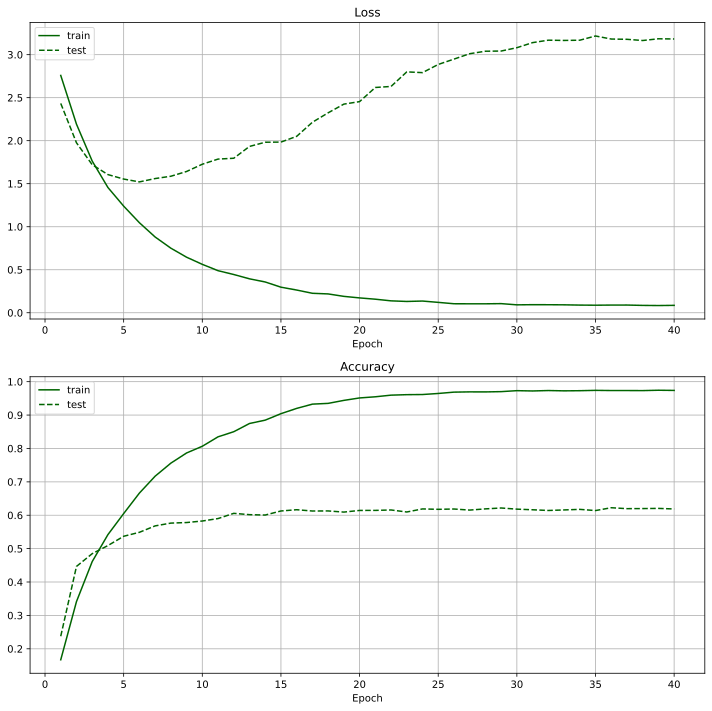

In [17]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

axes[0].plot(np.arange(40) + 1, loss_train, label='train', linestyle='-', c='darkgreen')

axes[0].plot(np.arange(40) + 1, loss_test, label='test', linestyle='--', c='darkgreen')

axes[1].plot(np.arange(40) + 1, acc_train, label='train', linestyle='-', c='darkgreen')

axes[1].plot(np.arange(40) + 1, acc_test, label='test', linestyle='--', c='darkgreen')

axes[0].legend()
axes[0].grid(True)
axes[0].set_xlabel('Epoch')
axes[0].set_title('Loss')

axes[1].legend()
axes[1].grid(True)
axes[1].set_xlabel('Epoch')
axes[1].set_title('Accuracy')

fig.tight_layout()
plt.show()